✅ Geometry generated:
- Nodes: 25
- Panels: 40
0.02377641290737884


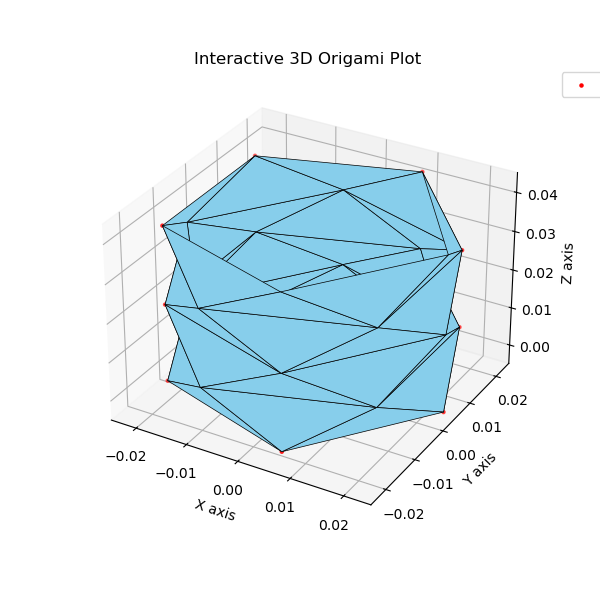

In [98]:
import numpy as np
%matplotlib widget


# === Define geometry and material parameters ===
N = 5             # Number of polygon sides
h = 10 / 1000             # Height of each layer
lyr = 5           # Number of layers
phi = -np.pi / 5   # Twist angle per layer (can also be a list)
# phi = 2 * np.pi / 8   # Twist angle per layer (can also be a list)
r = 25 / 1000

MaxIcr = 180       # Max number of increments
blam = 0.032       # Initial load factor

Kf = 1e-3          # Folding stiffness
Kb = Kf            # Bending stiffness
E0 = 5e3           # Stretching stiffness
Abar = 0.1         # Uniform cross-sectional area

limlft = 90       # Linear limit left (deg)
limrht = 310       # Linear limit right (deg)

# === Generate node coordinates and triangular panel connectivity ===
Node, Panel = get_di_sim(N, h, lyr, phi, r)


def rotate_z_deg(nodes, angle_deg):
    """Rotate all 3D points around the Z axis by a given angle in degrees."""
    theta = np.radians(angle_deg)
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta),  np.cos(theta), 0],
                  [0,              0,             1]])
    return nodes @ R.T


# Node = rotate_z_deg(Node, -90)

# === Print summary ===
print(f"✅ Geometry generated:\n- Nodes: {Node.shape[0]}\n- Panels: {len(Panel)}")
print( np.max(Node[1]))

plot_ori(Node, Panel)

In [99]:
indsupp = np.where(Node[:, 2] < 0.01)[0]
nsupp = len(indsupp)

Supp = np.zeros((nsupp, 4), dtype=int)
Supp[0, :] = [indsupp[0], 1, 1, 1]
Supp[1, :] = [indsupp[1], 1, 1, 1]
Supp[2:, 0] = indsupp[2:]
Supp[2:, 1:] = np.array([1, 1, 1])  # equivalent to MATLAB's zeros + 1 and ones

# Define number of nodes
m = Node.shape[0]

# Find nodes at the top (max z)
indp = np.where(np.abs(Node[:, 2] - np.max(Node[:, 2])) < 1e-5)[0]
npp = len(indp)

# Define Load
Lo = 0.5
Load = np.column_stack((indp, np.zeros((npp, 2)), -Lo * np.ones(npp)))


In [100]:
truss, angles, F = PrepareData(Node, Panel, Supp, Load, BarMater , RotSpring , Kf, Abar) ; 

In [101]:
print( np.max( Node[:,2] ) )

0.04


In [102]:
Node[1,:]

array([0.00772542, 0.02377641, 0.        ])

In [103]:
Bars = truss['Bars']  

# Define the Z bounds
z_min = 0.009
z_max = 0.031

# Get Z-coordinates of each node in the bars
z1 = Node[Bars[:, 0], 2]
z2 = Node[Bars[:, 1], 2]

# Create mask where both nodes are within the Z bounds
mask = (z1 >= z_min) & (z1 <= z_max) & (z2 >= z_min) & (z2 <= z_max)

# Filtered bars
subset_bars = Bars[mask]

In [ ]:
import json

# Convert to serializable format
export_data = {
    "Nodes": Node.tolist(),
    "Bars": subset_bars.tolist()
}

# Export to JSON file
with open("subset_structure.json", "w") as f:
    json.dump(export_data, f, indent=4)

print("Exported to subset_structure.json")

Exported to subset_structure.json


: 

In [96]:
import json
import numpy as np

# Example: Node and subset_bars should already be NumPy arrays
# Node: shape (N, 3)
# subset_bars: shape (M, 2)

# Build bar info with parametric line functions
bars_with_functions = []

for bar in subset_bars:
    start = Node[bar[0]]
    end = Node[bar[1]]
    direction = end - start  # Direction vector of the line

    bars_with_functions.append({
        "start": start.tolist(),
        "end": end.tolist(),
        "line_function": direction.tolist()  # Represents r(t) = start + t * direction
    })

# Wrap into dictionary
export_data = {
    "bars": bars_with_functions
}

# Export to JSON
with open("bars_with_functions.json", "w") as f:
    json.dump(export_data, f, indent=4)

print("Exported to bars_with_functions.json")

Exported to bars_with_functions.json


In [97]:
import json
import numpy as np

# Read JSON file
with open("subset_structure.json", "r") as f:
    data = json.load(f)

# Convert back to NumPy arrays
Node2 = np.array(data["Nodes"])
subset_bars2 = np.array(data["Bars"])

print("Loaded Node shape:", Node.shape)
print("Loaded subset_bars shape:", subset_bars.shape)

Loaded Node shape: (25, 3)
Loaded subset_bars shape: (35, 2)


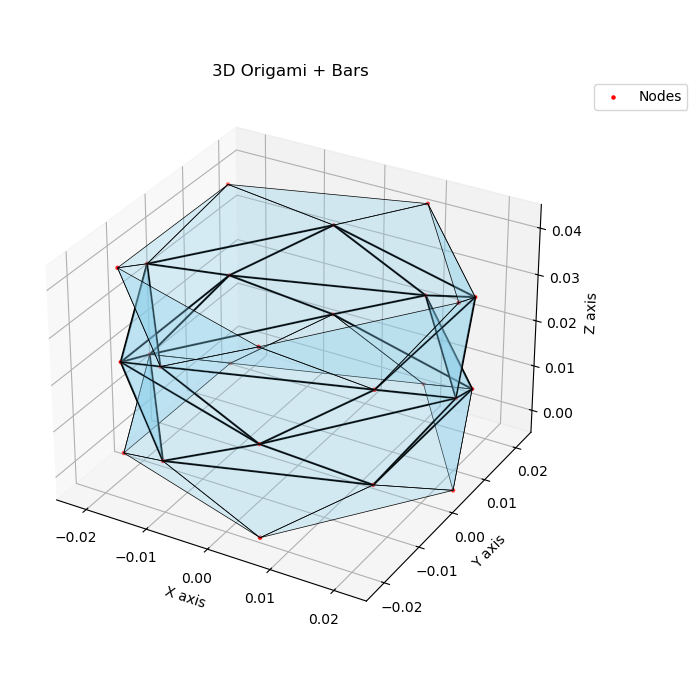

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def plot_ori_with_bars(Node, Panel, Bars=None, bar_colors=None, panel_color='skyblue', alpha=0.3):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(Node[:, 0], Node[:, 1], Node[:, 2], c='red', s=5, label='Nodes')

    # Plot origami panels (unchanged)
    faces = [Node[np.array(p)] for p in Panel]
    poly = Poly3DCollection(faces, facecolors=panel_color, edgecolors='k', linewidths=0.5)
    poly.set_alpha(alpha)
    ax.add_collection3d(poly)

    # Plot bars with optional per-bar color
    if Bars is not None:
        if bar_colors is not None and len(bar_colors) == len(Bars):
            for (i, bar) in enumerate(Bars):
                p1, p2 = Node[bar[0]], Node[bar[1]]
                ax.plot(*zip(p1, p2), color=bar_colors[i], linewidth=2)
        else:
            # One color for all bars
            for bar in Bars:
                p1, p2 = Node[bar[0]], Node[bar[1]]
                ax.plot(*zip(p1, p2), color='black', linewidth=1.5)

    # Labels and legend
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("3D Origami + Bars")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

    # Equal aspect ratio
    max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
    mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)

    plt.tight_layout()
    plt.show()

plot_ori_with_bars(Node, Panel, subset_bars)

In [56]:
truss['Bars'].shape

(65, 2)

In [35]:
truss['U0'] = np.zeros((3 * truss['Node'].shape[0],))
# IF, K = GlobalK_edu_ver( truss['U0'] , Node , truss , angles ) ; 
U_his , LF_his , Data = PathAnalysis( truss , angles , F, blam , MaxIcr ) ;

icrm = 1, lambda = 0.0000
    iter = 1, err = 1.849e-04, dlambda = 3.200e-02
    iter = 2, err = 2.176e-09, dlambda = -7.593e-06
Increase constraint radius!
icrm = 2, lambda = 0.0320
    iter = 1, err = 2.773e-04, dlambda = 4.798e-02
    iter = 2, err = 4.897e-09, dlambda = -1.708e-05
Increase constraint radius!
icrm = 3, lambda = 0.0800


/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_90832/3793186054.py:536: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dot_rnk_rij = float(rnk.T @ rij)
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_90832/3793186054.py:539: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_theta = float(rmj.T @ rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk))
/var/folders/mv/k1gy43r50tq3vsmhxgpcdyrc0000gn/T/ipykernel_90832/3793186054.py:549: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operati

    iter = 1, err = 4.160e-04, dlambda = 7.191e-02
    iter = 2, err = 1.102e-08, dlambda = -3.842e-05
Increase constraint radius!
icrm = 4, lambda = 0.1518
    iter = 1, err = 6.240e-04, dlambda = 1.078e-01
    iter = 2, err = 2.479e-08, dlambda = -8.640e-05
Increase constraint radius!
icrm = 5, lambda = 0.2595
    iter = 1, err = 9.360e-04, dlambda = 1.614e-01
    iter = 2, err = 5.579e-08, dlambda = -1.943e-04
Increase constraint radius!
icrm = 6, lambda = 0.4207
    iter = 1, err = 1.404e-03, dlambda = 2.415e-01
    iter = 2, err = 1.255e-07, dlambda = -4.366e-04
Increase constraint radius!
icrm = 7, lambda = 0.6617
    iter = 1, err = 2.106e-03, dlambda = 3.609e-01
    iter = 2, err = 2.825e-07, dlambda = -9.808e-04
Increase constraint radius!
icrm = 8, lambda = 1.0217
    iter = 1, err = 3.159e-03, dlambda = 5.384e-01
    iter = 2, err = 6.359e-07, dlambda = -2.202e-03
Increase constraint radius!
icrm = 9, lambda = 1.5579
    iter = 1, err = 4.738e-03, dlambda = 8.010e-01
    ite

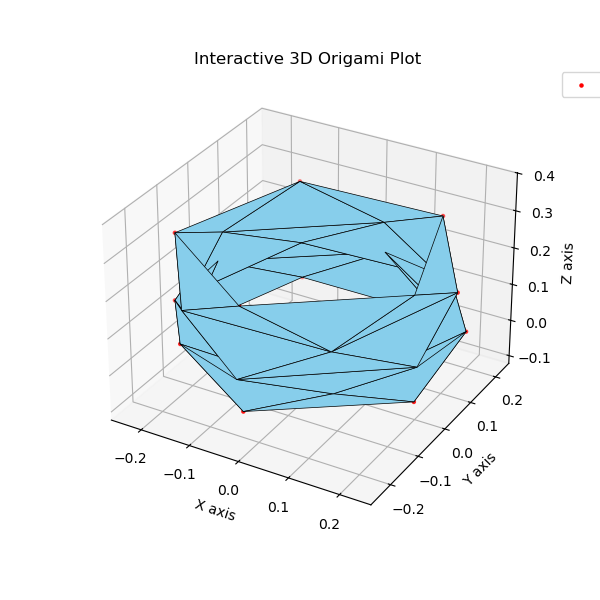

In [20]:
# Take the last displacement vector from Uhis
Ux = U_his[:, -1]  # shape (3*Nn,)

# Copy original node coordinates
Nodew = truss['Node'].copy()

# Apply displacements
Nodew[:, 0] += Ux[0::3]
Nodew[:, 1] += Ux[1::3]
Nodew[:, 2] += Ux[2::3]

plot_ori(Nodew, Panel)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ori(Node, Panel, ax, color='skyblue', alpha=1.0, linestyle='-', edge_color='k'):
    faces = [Node[np.array(p)] for p in Panel]
    poly = Poly3DCollection(faces, facecolors=color, edgecolors=edge_color,
                            linewidths=1.0)
    poly.set_alpha(alpha)
    ax.add_collection3d(poly)

def visual_fold_3(U_his, truss, angles, pausetime=0.1):
    Node = truss['Node']
    Panel = angles['Panel']

    # ⚠️ Create figure only ONCE
    plt.ion()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(U_his.shape[1]):
        ax.clear()

        # Update node positions
        U = U_his[:, i]
        Nodew = Node.copy()
        Nodew[:, 0] += U[0::3]
        Nodew[:, 1] += U[1::3]
        Nodew[:, 2] += U[2::3]

        # Plot undeformed and deformed
        plot_ori(Node, Panel, ax, color='lightgray', alpha=0.3, edge_color='gray')
        plot_ori(Nodew, Panel, ax, color='steelblue', alpha=1.0, edge_color='black')

        # Equal aspect ratio and bounds
        max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
        mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
        ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
        ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
        ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)
        ax.set_box_aspect([1,1,1])

        ax.set_title(f"Frame {i+1}/{U_his.shape[1]}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.pause(pausetime)

    plt.ioff()
    plt.show()

In [ ]:
%matplotlib qt 

visual_fold_3(U_his, {'Node': Node}, {'Panel': Panel}, pausetime=0.05)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# from PIL import Image  # Uncomment if saving to GIF
# import imageio         # Or use imageio for gif export

def animate_force_displacement(U_his, LF_his, instdof, pausetime=0.05,
                                axislim=None, recordtype='none', filename='animation.gif'):
    """
    Animates the force-displacement curve from simulation history.

    Parameters:
    - U_his: (ndarray) history of displacement vectors (3N x T)
    - LF_his: (ndarray) history of load factor values (T,)
    - instdof: (int) index of DOF to track (± for direction)
    - pausetime: (float) pause between frames
    - axislim: (list) [xmin, xmax, ymin, ymax] for plot axes
    - recordtype: 'none', 'imggif', or 'video'
    - filename: filename to save gif/video
    """

    dsp = np.sign(instdof) * U_his[abs(instdof), :]

    plt.ion()
    fig, ax = plt.subplots(figsize=(6, 5))
    frames = []  # For GIF export

    for i in range(len(LF_his)):
        ax.clear()

        # Plot history up to current step
        ax.plot(dsp[:i+1], LF_his[:i+1], 'b-', linewidth=2)
        ax.plot(dsp[i], LF_his[i], 'ro', linewidth=2)

        # Formatting
        ax.set_xlabel("Displacement", fontsize=14)
        ax.set_ylabel("Load Factor", fontsize=14)
        ax.set_title(f"Step {i+1}/{len(LF_his)}")
        ax.grid(True)
        if axislim:
            ax.set_xlim(axislim[0], axislim[1])
            ax.set_ylim(axislim[2], axislim[3])

        plt.pause(pausetime)

        # Optional: GIF recording (commented)
        # if recordtype == 'imggif':
        #     fig.canvas.draw()
        #     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        #     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        #     frames.append(image.copy())

    plt.ioff()
    plt.show()

    # Optional: save to GIF (commented)
    # if recordtype == 'imggif':
    #     imageio.mimsave(filename, frames, duration=pausetime)

    # Optional: save to video (use OpenCV or imageio-ffmpeg)

In [24]:
instdof = -indp[0]*3;
dsp = np.sign(instdof) * U_his[abs(instdof), :]
xmin, xmax = dsp.min(), dsp.max()
ymin, ymax = LF_his.min(), LF_his.max()

xpad = 0.05 * (xmax - xmin)
ypad = 0.05 * (ymax - ymin)

axislim = [xmin - xpad, xmax + xpad, ymin - ypad, ymax + ypad]

In [80]:
axislim

[np.float64(-0.008053355999620178),
 np.float64(0.16912047599202373),
 np.float64(-0.16851233094385776),
 np.float64(3.538758949821013)]

In [25]:
animate_force_displacement(U_his, LF_his, instdof=12, pausetime=0.05,
                           axislim=axislim)

In [26]:
print( Node.shape )
print( U_his.shape )
Ux = U_his[: , -1 ]
print(Ux.shape)
print(Ux[2::3])

(25, 3)
(75, 181)
(75,)
[ 0.          0.          0.          0.          0.         -0.01000277
 -0.01335707 -0.01577034 -0.00774783 -0.01838121 -0.11648089 -0.10068528
 -0.10361317 -0.10317347 -0.11329391 -0.13005904 -0.12414612 -0.11484928
 -0.11546911 -0.12495687 -0.13603663 -0.13535283 -0.12533335 -0.12075901
 -0.12610417]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FFMpegWriter

def plot_ori(Node, Panel, ax, color='skyblue', alpha=1.0, linestyle='-', edge_color='k'):
    faces = [Node[np.array(p)] for p in Panel]
    poly = Poly3DCollection(faces, facecolors=color, edgecolors=edge_color,
                            linewidths=1.0)
    poly.set_alpha(alpha)
    ax.add_collection3d(poly)

def visual_fold_3(U_his, truss, angles, pausetime=0.1, save_as=None):
    Node = truss['Node']
    Panel = angles['Panel']

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Optional video writer
    if save_as is not None:
        writer = FFMpegWriter(fps=int(1/pausetime), metadata=dict(artist='Hugo'), bitrate=1800)
        with writer.saving(fig, save_as, dpi=100):
            for i in range(U_his.shape[1]):
                ax.clear()

                # Update node positions
                U = U_his[:, i]
                Nodew = Node.copy()
                Nodew[:, 0] += U[0::3]
                Nodew[:, 1] += U[1::3]
                Nodew[:, 2] += U[2::3]

                # Plot
                plot_ori(Node, Panel, ax, color='lightgray', alpha=0.3, edge_color='gray')
                plot_ori(Nodew, Panel, ax, color='steelblue', alpha=1.0, edge_color='black')

                # Axes limits and labels
                max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
                mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
                ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
                ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
                ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)
                ax.set_box_aspect([1,1,1])

                ax.set_title(f"Frame {i+1}/{U_his.shape[1]}")
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')

                writer.grab_frame()
        plt.close(fig)
    else:
        plt.ion()
        for i in range(U_his.shape[1]):
            ax.clear()

            U = U_his[:, i]
            Nodew = Node.copy()
            Nodew[:, 0] += U[0::3]
            Nodew[:, 1] += U[1::3]
            Nodew[:, 2] += U[2::3]

            plot_ori(Node, Panel, ax, color='lightgray', alpha=0.3, edge_color='gray')
            plot_ori(Nodew, Panel, ax, color='steelblue', alpha=1.0, edge_color='black')

            max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
            mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
            ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
            ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
            ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)
            ax.set_box_aspect([1,1,1])

            ax.set_title(f"Frame {i+1}/{U_his.shape[1]}")
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            plt.pause(pausetime)
        plt.ioff()
        plt.show()

In [68]:
visual_fold_3(U_his, truss, angles, pausetime=0.1, save_as='kresling_simulation.mp4')

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.sparse import coo_matrix

def PrepareData(Node, Panel, Supp, Load, BarCM, RotSpring, kpf, Abar):

    # Bend = findbend(Panel, Node);

    # Find folds and boundaries
    Fold, Bdry, Trigl = findfdbd(Panel)
    
    # Combine bars from folds and boundaries
    Bars = np.vstack((Fold[:, :2], Bdry))
    
    # Compute bar directions and lengths
    B, L = dirc3d(Node, Bars)

    if Supp.shape[0] == 0:
        rs = np.array([], dtype=int)
    else:
        # Generate the first column (flattened index mapping)
        idx = np.vstack((Supp[:, 0]*3-2 , Supp[:, 0]*3-1 , Supp[:, 0]*3)).T.flatten()
        val = Supp[:, 1:4].T.flatten()

        rs = np.vstack((idx, val)).T

        # Remove rows where the second column is zero
        rs = rs[rs[:, 1] != 0]
        rs = rs[:, 0]  # Only keep the index values
        rs += 2 

    # Expand Abar if it's a scalar
    if np.isscalar(Abar):
        Abar = Abar * np.ones((Bars.shape[0], 1))
    
    # Compute initial fold angles
    pf0 = np.zeros((Fold.shape[0],))
    for i in range(Fold.shape[0]):
        pf0[i] = FoldKe_prepareData(Node, Fold[i,:])
    
    m = Node.shape[0]
    F = np.zeros((3 * m,))
    indp = Load[:, 0].astype(int)
    F[3 * indp] = Load[:, 1]
    F[3 * indp+1] = Load[:, 2]
    F[3 * indp+2] = Load[:, 3]

    # Build result structures
    truss = {
        "CM": BarCM,
        "Node": Node,
        "Bars": Bars,
        "Trigl": Trigl,
        "B": B,
        "L": L,
        "FixedDofs": np.unique(rs),
        "A": Abar
    }

    angles = {
        "CM": RotSpring,
        "fold": Fold,
        "kpf": kpf * np.ones((1, Fold.shape[0])),
        "pf0": pf0.reshape(1, -1),
        "Panel": Panel
    }

    return truss, angles, F


def GetData(Ui, Node, truss, angles ):

    Nb = truss['Bars'].shape[0]
    Na = angles['fold'].shape[0]

    Exbar = np.zeros(Nb)
    FdAngle = np.zeros(Na)
    LFd = np.zeros(Na)

    # Reconstruct deformed nodal positions
    Nodenw = Node.copy()
    Nodenw[:, 0] += Ui[0::3]
    Nodenw[:, 1] += Ui[1::3]
    Nodenw[:, 2] += Ui[2::3]

    for bel in range(Nb):
        node1, node2 = truss['Bars'][bel]
        eDof = np.array([
        node1 * 3, node1 * 3 + 1, node1 * 3 + 2,
        node2 * 3, node2 * 3 + 1, node2 * 3 + 2
        ])

        u_local = Ui[eDof]
        # B_local = truss['B'].getrow(bel).toarray()[0][eDof]  # row of B for bar `bel` restricted to eDof
        row_slice = truss["B"].tocsr()[bel, :]  ; 
        sub_row = row_slice[:, eDof] ; 
        B_local = sub_row.tocoo() ; 
        L_local = truss['L'][bel]

        Exbar[bel] = BarKe_SingleOut(u_local, B_local, L_local)

    for fel in range(Na):
        fold = angles['fold'][fel]
        FdAngle[fel] = FoldKe_prepareData( Nodenw , fold ) ; 
        LFd[fel] = np.linalg.norm(Nodenw[fold[1], :] - Nodenw[fold[0], :])


    return Exbar , FdAngle , LFd 


def PathAnalysis( truss , angles, F , b_lambda , MaxIcr ):

    tol = 1e-6
    MaxIter = 50

    Node = truss['Node']
    num_nodes = Node.shape[0]
    num_dofs = 3 * num_nodes

    AllDofs = np.arange(0, num_dofs)  

    U = truss['U0']

    Data = {}
    Uhis = np.zeros((num_dofs, MaxIcr + 1))
    Data['Exbar'] = np.zeros((truss['Bars'].shape[0], MaxIcr + 1))
    Data['FdAngle'] = np.zeros((angles['fold'].shape[0], MaxIcr + 1))
    Data['LFdAngle'] = Data['FdAngle'] 

    load_his = np.zeros((MaxIcr + 1,))

    FreeDofs = np.setdiff1d(AllDofs, truss['FixedDofs'])

    lmd = 0
    icrm = 0
    MUL = np.column_stack((U, U))  # Equivalent to [U, U] in MATLAB


    while icrm < MaxIcr:
        icrm += 1
        iter = 0
        err = 1.0
        print(f"icrm = {icrm}, lambda = {lmd:.4f}")

        while err > tol and iter < MaxIter:
            iter += 1

            # Assemble internal force and stiffness matrix
            IF, K = GlobalK_edu_ver( U , Node , truss , angles )  # you must provide this function

            R = lmd * F - IF
            MRS = np.column_stack((F, R))

            # Solve for predictor and corrector direction vectors
            # Kff = K[np.ix_(FreeDofs , FreeDofs )]
            Kff_dense = K[np.ix_(FreeDofs, FreeDofs)].toarray()
            MRSf = MRS[FreeDofs, :]  # assuming MRS is densex
            # MUL[FreeDofs, :] = np.linalg.solve(Kff, MRSf)
            MUL[FreeDofs, :] = np.linalg.solve(Kff_dense, MRSf)

            dUp = MUL[:, 0]
            dUr = MUL[:, 1]

            if iter == 1:
                dUr = np.zeros_like(dUr)

            # Compute incremental load factor
            dlmd = nlsmgd(icrm, iter, dUp, dUr, b_lambda)
            dUt = dlmd * dUp + dUr
            U = U + dUt
            err = np.linalg.norm(dUt[FreeDofs])  
            lmd = lmd + dlmd
            print(f'    iter = {iter}, err = {err:.3e}, dlambda = {dlmd:.3e}')
            if err > 1e8:
                print('Divergence!')
                break

        if iter > 15:
            b_lambda = b_lambda / 2
            print('Reduce constraint radius!')
            icrm = icrm - 1
            U = Uhis[:, max(icrm, 0)]  # Python uses 0-based indexing
            lmd = load_his[max(icrm, 0)]

        elif iter < 3:
            print('Increase constraint radius!')
            b_lambda = b_lambda * 1.5
            Uhis[:, icrm] = U
            load_his[icrm] = lmd

            # Exbari = GetData(U, Node, truss)
            Exbari, FdAnglei, LFdAnglei = GetData(U, Node, truss, angles)
            Data['Exbar'][:, icrm] = Exbari
            Data['FdAngle'][:, icrm] = FdAnglei
            Data['LFdAngle'][:, icrm] = LFdAnglei

        else:
            Uhis[:, icrm] = U
            load_his[icrm] = lmd

            Exbari, FdAnglei, LFdAnglei = GetData(U, Node, truss, angles)
            Data['Exbar'][:, icrm] = Exbari
            Data['FdAngle'][:, icrm] = FdAnglei
            Data['LFdAngle'][:, icrm] = LFdAnglei
        
    # Trim arrays
    icrm += 1 ; 
    Uhis = Uhis[:, :icrm] ; 
    load_his = load_his[:icrm] ; 
    Data['Exbar'] = Data['Exbar'][:, :icrm] ;   
    Data['FdAngle'] = Data['FdAngle'][:, :icrm] ;   
    Data['LFdAngle'] = Data['LFdAngle'][:, :icrm] ;   
     

    return Uhis , load_his , Data 

# Globals
dupp1 = None
sinal = 1
dupc1 = None
numgsp = None

def nlsmgd(step, ite, dup, dur, cmp):

    global dupp1, sinal, dupc1, numgsp

    if step == 1 and ite == 1:
        sinal = 1
        dupp1 = dup.copy()

    if ite == 1:
        sinal *= np.sign(np.dot(dupp1, dup))
        dupp1 = dup.copy()

    if ite == 1:
        if step == 1:
            dl = cmp
            numgsp = np.dot(dup, dup)
            dupc1 = dup.copy()
        else:
            gsp = numgsp / np.dot(dup, dup)
            dl = sinal * cmp * np.sqrt(gsp)
            dupc1 = dup.copy()
    else:
        dl = -np.dot(dupc1, dur) / np.dot(dupc1, dup)

    return dl

import numpy as np
from scipy.sparse import coo_matrix

def GlobalK_edu_ver(Ui, Node, truss, angle):

    Nn = Node.shape[0]
    IFb = np.zeros(3 * Nn)
    IFp = np.zeros(3 * Nn)

    num_bars = truss["Bars"].shape[0]
    indi = np.zeros(36 * num_bars, dtype=int)
    indj = np.zeros(36 * num_bars, dtype=int)
    kentry = np.zeros(36 * num_bars, dtype=float)

    # New deformed node positions
    Nodenw = np.zeros_like(Node)
    Nodenw[:, 0] = Node[:, 0] + Ui[0::3]
    Nodenw[:, 1] = Node[:, 1] + Ui[1::3]
    Nodenw[:, 2] = Node[:, 2] + Ui[2::3]


    for bel in range(num_bars):
        n1 = truss["Bars"][bel, 0]
        n2 = truss["Bars"][bel, 1]
        eDof = np.array([3*n1, 3*n1+1, 3*n1+2, 3*n2, 3*n2+1, 3*n2+2])

        u = Ui[eDof] ; 
        row_slice = truss["B"].tocsr()[bel, :]  ; 
        sub_row = row_slice[:, eDof] ; 
        B = sub_row.tocoo() ; 
        L = truss["L"][bel] ; 
        CM = truss["CM"] ; 
        A = truss["A"][bel] ; 

        _ , Rbe , Kbe = BarKe(u, B, L, CM, A)

        
        IFb[eDof] += Rbe[0]
        # print(f'IFb[eDof] = {IFb[eDof]}')
        # print(f'Rbe[0] = {Rbe[0]}')

        I = np.tile(eDof[:, np.newaxis], (1, 6))
        J = I.T
        offset = 36 * bel
        o = np.arange(offset,offset+36, 1)
        indi[o] = J.flatten()
        indj[o] = I.flatten()
        kentry[o] = Kbe.flatten()

    Kb = coo_matrix((kentry, (indi, indj)), shape=(3*Nn, 3*Nn)).tocsc()

    num_folds = angle["fold"].shape[0]
    indi = np.zeros(144 * num_folds, dtype=int)
    indj = np.zeros(144 * num_folds, dtype=int)
    kentry = np.zeros(144 * num_folds, dtype=float)
    # Lfold = truss["L"][:num_folds]  # Assuming fold bars are first
    Lfold = truss['L'][0:angles['fold'].shape[0]] ; 

    for fel in range(num_folds):
        fold = angle["fold"][fel]
        eDof = np.ravel([[3*i, 3*i+1, 3*i+2] for i in fold])
        
        _ , Rpe, Kpe = FoldKe(Nodenw, fold, angle["kpf"][0], angle["pf0"][0][fel], Lfold[fel], angle["CM"])
    
        # print(f'IFp[eDof] = {IFp[eDof]}')
        # print(f'Rpe.reshape(-1) = {Rpe.reshape(-1)}')
        # IFp[eDof] += Rpe.flatten()
        IFp[eDof] += Rpe.reshape(-1)
    
        I = np.tile(eDof[:, np.newaxis], (1, 12))
        J = I.T
        offset = 144 * fel
        o = np.arange(offset,offset+144, 1)
        indi[o] = J.flatten()
        indj[o] = I.flatten()
        kentry[o] = Kpe.flatten()

    Kfd = coo_matrix((kentry, (indi, indj)), shape=(3*Nn, 3*Nn)).tocsc()


    # IF = IFb
    # print(f'IFb = {IFb}')
    # print(f'IFp = {IFp}')
    IF = IFb + IFp
    # K = Kb
    K = Kb + Kfd
    K = (K + K.T) * 0.5  # Ensure symmetry

    return IF, K 


def icross(a, b):
    c = np.array([
        a[1] * b[2] - a[2] * b[1],
        a[2] * b[0] - a[0] * b[2],
        a[0] * b[1] - a[1] * b[0]
    ])
    return c

def findbend(panel, node):
    bend = []
    for p in panel:
        if len(p) == 4:
            L1 = np.linalg.norm(node[p[0] - 1] - node[p[2] - 1])
            L2 = np.linalg.norm(node[p[3] - 1] - node[p[1] - 1])
            if L1 > L2:
                lclbend = [p[1], p[3], p[0], p[2]]
            else:
                lclbend = [p[0], p[2], p[1], p[3]]
            bend.append(lclbend)
    return np.array(bend)

def findfdbd(Panel):
    Nn = max(max(p) for p in Panel)
    panelsize = [len(p) for p in Panel]

    Ptri = [Panel[i] for i in range(len(Panel)) if panelsize[i] == 3]

    Triglraw = np.vstack([
        np.array(Ptri)
    ])

    Trigl = np.unique(np.sort(Triglraw, axis=1), axis=0)

    # Assume Trigl is already defined as a (n_triangles, 3) ndarray
    Nn = np.max(Trigl) + 1  # number of nodes

    # --- Build Comm matrix (shape: Nn x n_triangles) ---
    row_idx = []
    col_idx = []
    data = []

    for i in range(Trigl.shape[0]):
        for node in Trigl[i]:
            row_idx.append(node)
            col_idx.append(i)
            data.append(1)

    Comm = coo_matrix((data, (row_idx, col_idx)), shape=(Nn, Trigl.shape[0]), dtype=int)

    # --- Compute Ge = Comm.T @ Comm ---
    Ge = (Comm.transpose().dot(Comm)).tocoo()

    # --- Find pairs of triangles that share 2 nodes ---
    Ge_dense = Ge.toarray()
    mf, me = np.where(np.triu(Ge_dense == 2))  # upper triangular part only

    # --- Build fold array ---
    fold = np.zeros((len(mf), 4), dtype=int)

    for i in range(len(mf)):
        t1 = Trigl[mf[i]]
        t2 = Trigl[me[i]]
        
        # Find shared nodes and their indices
        link, ia, ib = np.intersect1d(t1, t2, return_indices=True)
        
        oftpa = [j for j in range(3) if j not in ia]
        oftpb = [j for j in range(3) if j not in ib]

        fold[i, :] = np.concatenate([link, [t1[oftpa[0]], t2[oftpb[0]]]])

    Fold = fold[np.argsort(fold[:, 0])]

    Edge = np.sort(
        np.vstack([
            Trigl[:, [0, 1]],
            Trigl[:, [1, 2]],
            Trigl[:, [2, 0]]
        ]), axis=1
    )

    u, inv, count = np.unique(Edge, axis=0, return_inverse=True, return_counts=True)
    bdry = u[count == 1]

    return Fold, bdry, Trigl

def get_di_sim(N,h,lyr,phi, r):

    if np.isscalar(phi):
        rotangle = np.arange(lyr) * phi
    else:
        rotangle = np.array(phi)

    # Compute angular positions for each layer
    rdl = np.zeros((lyr, N))
    for i in range(lyr):
        rdl[i, :] = np.linspace(rotangle[i], 2 * np.pi / N * (N - 1) + rotangle[i], N)

    # Flatten node coordinates correctly for any lyr
    Xcood = r * np.cos(rdl).reshape(-1)
    Ycood = r * np.sin(rdl).reshape(-1)
    Zcood = np.repeat(np.arange(lyr), N) * h

    Node = np.column_stack((Xcood, Ycood, Zcood))

    # Build triangular panels
    Panel = []
    for i in range(lyr - 1):
        offset = i * N
        for j in range(N):
            a = offset + j
            b = offset + j + N
            c1 = offset + (j + 1) % N + N
            c2 = offset + (j + 1) % N

            Panel.append([a, b, c1])
            Panel.append([a, c2, c1])

    return Node, Panel

def plot_ori(Node, Panel, color='skyblue', alpha=1.0):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(Node[:, 0], Node[:, 1], Node[:, 2], c='red', s=5, label='Nodes')

    # Plot panels
    faces = [Node[np.array(p)] for p in Panel]  # Already zero-based indexing
    poly = Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.5)
    poly.set_alpha(alpha)
    ax.add_collection3d(poly)

    # Axes labels and title
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("Interactive 3D Origami Plot")
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

    # Equal aspect ratio
    max_range = (Node.max(axis=0) - Node.min(axis=0)).max()
    mid = (Node.max(axis=0) + Node.min(axis=0)) / 2
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)

    # Optional: turn axis on or off
    # ax.axis('off')

    plt.show()



    
def FoldKe_prepareData(Coord, List):


    rkj = np.transpose( Coord[List[1]] - Coord[List[0]] )
    rij = np.transpose( Coord[List[2]] - Coord[List[0]] )
    rkl = np.transpose( Coord[List[1]] - Coord[List[3]] )

    rmj = icross(rij,rkj); rnk = icross(rkj,rkl);

    dot_rnk_rij = np.dot(rnk, rij)
    sgn = np.sign(dot_rnk_rij) if abs(dot_rnk_rij) > 1e-8 else 1

    cos_theta = np.dot(rmj, rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk))
    # Clamp to avoid domain error in case of numerical imprecision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    he = float(sgn) * np.arccos(cos_theta)

    if he < 0:
        he = 2 * np.pi + he ;
    
    return he 

def FoldKe(Coord, List, kpi, h0, L0, CM):
    
    # print(f'Coord = {Coord}')
    # print(f'List = {List}')
    # print(f'kpi = {kpi}')
    # print(f'h0 = {h0}')
    # print(f'L0 = {L0}')
    # --- Retrieve vectors (as column vectors) ---
    p0, p1, p2, p3 = Coord[List]  # List is assumed 0-indexed
    rkj = (p1 - p0).reshape(3, 1)
    rij = (p2 - p0).reshape(3, 1)
    rkl = (p1 - p3).reshape(3, 1)

    # --- Cross products ---
    rmj = np.cross(rij.T, rkj.T).T  # shape (3, 1)
    rnk = np.cross(rkj.T, rkl.T).T  # shape (3, 1)

    # --- Angle computation ---
    dot_rnk_rij = float(rnk.T @ rij)
    sgn = np.sign(dot_rnk_rij) if np.abs(dot_rnk_rij) > 1e-8 else 1

    cos_theta = float(rmj.T @ rnk) / (np.linalg.norm(rmj) * np.linalg.norm(rnk))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    he = sgn * np.arccos(cos_theta)
    if he < 0:
        he += 2 * np.pi

    [Rspr, Kspr] = CM(he,h0,kpi,L0);

    # --- Precomputations ---
    norm_rkj = np.linalg.norm(rkj)
    rmj_dot = float(rmj.T @ rmj)
    rnk_dot = float(rnk.T @ rnk)
    rkj_dot = float(rkj.T @ rkj)
    rij_dot_rkj = float(rij.T @ rkj)
    rkl_dot_rkj = float(rkl.T @ rkj)

    # --- Gradient vectors ---
    di = (norm_rkj / rmj_dot) * rmj
    dl = -(norm_rkj / rnk_dot) * rnk
    dj = (rij_dot_rkj / rkj_dot - 1) * di - (rkl_dot_rkj / rkj_dot) * dl
    dk = -(rij_dot_rkj / rkj_dot) * di + (rkl_dot_rkj / rkj_dot - 1) * dl

    Jhe = np.vstack([dj, dk, di, dl])  # Shape (12, 1)
    Rhe = Rspr*Jhe;

    # --- Hessian blocks ---

    def outer_sum(a, b):
        return a @ b.T + b @ a.T

    # dii
    cr = np.cross(rkj.T, rmj.T).T
    dii = -norm_rkj / rmj_dot**2 * outer_sum(rmj, cr)

    # dij
    vec_ij = rij - rkj
    cr_ij = np.cross(vec_ij.T, rmj.T).T
    dtempij = -norm_rkj / rmj_dot**2 * outer_sum(rmj, cr_ij)
    dij = -rmj @ rkj.T / (rmj_dot * norm_rkj) + dtempij

    # dik
    cr_ik = np.cross(rij.T, rmj.T).T
    dtempik = norm_rkj / rmj_dot**2 * outer_sum(rmj, cr_ik)
    dik = rmj @ rkj.T / (rmj_dot * norm_rkj) + dtempik

    # dll
    cr_ll = np.cross(rkj.T, rnk.T).T
    dll = norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_ll)

    # dlk
    cr_lk = np.cross((rkl - rkj).T, rnk.T).T
    dlk = -rnk @ rkj.T / (rnk_dot * norm_rkj) + norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_lk)

    # dlj
    cr_lj = np.cross(rnk.T, rkl.T).T
    dlj = rnk @ rkj.T / (rnk_dot * norm_rkj) + norm_rkj / rnk_dot**2 * outer_sum(rnk, cr_lj)

    # dil (zero matrix)
    dil = np.zeros((3, 3))

    # --- djj, djk, dkk ---

    dT1jj = (1 / rkj_dot) * (((-1 + 2 * rij_dot_rkj / rkj_dot) * rkj) - rij)
    dT2jj = (1 / rkj_dot) * ((2 * rkl_dot_rkj / rkj_dot) * rkj - rkl)
    djj = di @ dT1jj.T + (rij_dot_rkj / rkj_dot - 1) * dij - (dl @ dT2jj.T + (rkl_dot_rkj / rkj_dot) * dlj)

    dT1jk = (1 / rkj_dot) * (-2 * rij_dot_rkj / rkj_dot * rkj + rij)
    dT2jk = (1 / rkj_dot) * ((1 - 2 * rkl_dot_rkj / rkj_dot) * rkj + rkl)
    djk = di @ dT1jk.T + (rij_dot_rkj / rkj_dot - 1) * dik - (dl @ dT2jk.T + (rkl_dot_rkj / rkj_dot) * dlk)

    # dkk (same pattern with flipped terms)
    dkk = dl @ dT1jk.T + (rkl_dot_rkj / rkj_dot - 1) * dlk - (di @ dT2jk.T + (rij_dot_rkj / rkj_dot) * dik)

    # --- Final 12x12 Hessian matrix ---
    Hp = np.block([
        [djj , djk , dij.T , dlj.T],
        [djk.T, dkk , dik.T , dlk.T],
        [dij , dik , dii   , dil  ],
        [dlj , dlk , dil.T , dll  ]
    ])

    Khe = Kspr * (Jhe @ Jhe.T) + Rspr * Hp

    return he, Rhe, Khe

# Define bar material constitutive
def BarMater(Ex):
    return Ogden_2(Ex, 5000.0)

# Define rotational spring constitutive
def RotSpring(he, h0, kpi, L0):
    return EnhancedLinear_TwoOut(he, h0, kpi, L0, limlft, limrht)

def Ogden_2(Ex, C0):
    alpha = [5, 1]
    pstr = np.real(np.sqrt(2 * Ex + 1))

    # C0 scaling is kept as-is (effectively no change)
    Et = C0 / (alpha[0] - alpha[1]) * ((alpha[0] - 2) * pstr**(alpha[0] - 4) - (alpha[1] - 2) * pstr**(alpha[1] - 4))
    Sx = C0 / (alpha[0] - alpha[1]) * (pstr**(alpha[0] - 2) - pstr**(alpha[1] - 2))

    # Optional third output
    # Wb = C0 / (alpha[0] - alpha[1]) * ((pstr**alpha[0] - 1) / alpha[0] - (pstr**alpha[1] - 1) / alpha[1])

    return Sx, Et

def EnhancedLinear_TwoOut(he,h0,kpi,L0,limlft_deg,limrht_deg):

    # print(f'he = {he}')
    # print(f'h0 = {h0}')
    # print(f'kpi = {kpi}')
    # print(f'L0 = {L0}')

    limlft = np.radians(limlft_deg)
    limrht = np.radians(limrht_deg)

    partl = np.pi / limlft
    partr = np.pi / (2 * np.pi - limrht)

    if he < limlft:
        Rspr = kpi[0] * (limlft - h0) + kpi[0] * np.tan(partl / 2 * (he - limlft)) / (partl / 2)
        Kspr = kpi[0] * (1 / np.cos(partl / 2 * (he - limlft)))**2
    elif he > limrht:
        Rspr = kpi[0] * (limrht - h0) + kpi[0] * np.tan(partr / 2 * (he - limrht)) / (partr / 2)
        Kspr = kpi[0] * (1 / np.cos(partr / 2 * (he - limrht)))**2
    else:
        Rspr = kpi[0] * (he - h0)
        Kspr = kpi[0]

    Rspr *= L0
    Kspr *= L0

    return Rspr, Kspr 

def dirc3d(Node, Ele):

    Ne = Ele.shape[0]
    Nn = Node.shape[0]

    # Compute direction vectors and normalize
    D = Node[Ele[:, 1], :] - Node[Ele[:, 0], :]
    L = np.linalg.norm(D, axis=1)
    D_unit = D / L[:, np.newaxis]

    # # Row indices: repeat element indices 6 times each
    # row = np.repeat(np.arange(Ne), 6)

    # # Column indices: 3 DOFs per node
    # col = np.hstack([
    # 3 * Ele[:, 0] + 0,  # x of node 1
    # 3 * Ele[:, 0] + 1,  # y of node 1
    # 3 * Ele[:, 0] + 2,  # z of node 1
    # 3 * Ele[:, 1] + 0,  # x of node 2
    # 3 * Ele[:, 1] + 1,  # y of node 2
    # 3 * Ele[:, 1] + 2   # z of node 2
    # ])

    # # Values: concatenate D and -D
    # data = np.hstack([D_unit, -D_unit]).flatten()

    # # Build sparse matrix B
    # B = coo_matrix((data, (row, col)), shape=(Ne, 3 * Nn))
    # print(B)

    # For each element, build the 6 triplets (3 DOFs per 2 nodes)
    row = []
    col = []
    data = []

    for i in range(Ne):
        n1, n2 = Ele[i]
        d = D_unit[i]

        # Node 1 contributions (positive)
        row.extend([i] * 3)
        col.extend([3 * n1 + j for j in range(3)])
        data.extend(d)

        # Node 2 contributions (negative)
        row.extend([i] * 3)
        col.extend([3 * n2 + j for j in range(3)])
        data.extend(-d)

    # Convert to numpy arrays
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)

    # Build sparse matrix without sorting
    B = coo_matrix((data, (row, col)), shape=(Ne, 3 * Nn))
    B = -B
    
    return B, L

from filecmp import cmp
import numpy as np

def BarKe(u, B, L, CM, A):

    du = u[:3] - u[3:] ;
    Du = np.concatenate((du, -du)) ;
    Bu = B @ u if B.ndim == 2 else np.dot(B, u)
    Ex = Bu / L + 0.5 * (du @ du) / (L ** 2)
    [Sx, Et] = CM(Ex)
    Fx = Sx * A

    Du_L = (Du / L).reshape(1, -1)
    B_plus = B.toarray() + Du_L
    Rbe = Fx[0] * B_plus

    B_dense = B.toarray().ravel()

    # Outer product
    Kel_dense = np.outer(B_dense, B_dense)
    Kel_sparse = coo_matrix(Kel_dense)
    Kel = Kel_sparse

    Kg = Fx / L * np.block([[np.eye(3), -np.eye(3)],
                    [-np.eye(3), np.eye(3)]])

    K1 = (np.outer(Du, B_dense) + np.outer(B_dense, Du)) / L
    K2 = np.outer(Du, Du) / (L ** 2)

    scalar = (Et[0] * A[0]) / L
    Kbe = scalar * (Kel.toarray() + K1 + K2) + Kg

    return Ex, Rbe, Kbe

# BarKe(u, B, L, CM, A)

def BarKe_SingleOut(u, B, L):

    du = u[:3] - u[3:] ;
    Bu = B @ u if B.ndim == 2 else np.dot(B, u)
    Ex = Bu / L + 0.5 * (du @ du) / (L ** 2)

    return Ex
